In [47]:
# from numpy import cov
import os
import pandas
import geopandas
from shapely.geometry import Point
import sys
import matplotlib
# from pytesmo.time_series.anomaly import calc_anomaly
# from pytesmo.time_series.anomaly import calc_anomaly
sys.path.append('../python')
sys.path.append('../../icos_data')
sys.path.append('../../ismn_data\HOBE_Data_2015-2018')
import sm_config as config
import sm_tools as tools
import sm_triplecollocation

In [35]:
def get_filenames(path_to_dir, suffix=".csv"):
    filenames = os.listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith(suffix) ]

In [36]:
def get_basemap(f, color="white", edgecolor="silver", figsize=(9,6)):
    base = geopandas.read_file(f)
    plot = base.plot(color=color, edgecolor=edgecolor, figsize=figsize)
    return plot

In [37]:
# grid evaluation metrics
def grid_metrics_output(grid_metrics_dir, output_dir, base_shp, include_months=False, metric="pearson_r", cutoff=100):
    base = get_basemap(base_shp)
#     sweden = geopandas.read_file(r"../basemap/SWE_adm0.shp")
    # sweden_shape.boundary.plot()
#     sweden = sweden_shape.plot(color='white', edgecolor='silver')
#     base = sweden.plot(color='white', edgecolor='silver', figsize=(9,6))
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    grid_metrics_csvs = get_filenames(grid_metrics_dir)
    map_legend = True
    for fn in grid_metrics_csvs:
        pn = fn.replace(" metrics.csv", "")
        pn_dir = os.path.join(output_dir, pn)
        if not os.path.exists(pn_dir):
            os.mkdir(pn_dir)
        f = os.path.join(grid_metrics_dir, fn)
        df = pandas.read_csv(f)
        df = df[['lon', 'lat', 'anomaly', 'timefilter', metric, 'pearson_sig']]
        # filter out insignificant and non-anomaly rows
        df_sub = df[(df.pearson_sig) & (df.anomaly == True)]
        # filter df_sub by timefilter values
        tfs = [tf for tf in df.timefilter.unique() if tf != "all"]
        if not include_months:
            tfs = [tf for tf in tfs if "M" not in tf]
        for timefilter in tfs:
#             matplotlib.pyplot.clf()
#         if timefilter == "No-Timefilter":
            tf_dir = os.path.join(output_dir, timefilter)
            if not os.path.exists(tf_dir):
                os.mkdir(tf_dir)
            df_tf = df_sub[df.timefilter == timefilter]
            # create and output map
            gm_geo = [Point(xy) for xy in zip(df_tf.iloc[:, 0], df_tf.iloc[:, 1])]
            gm_gdf = geopandas.GeoDataFrame(df_tf, geometry=gm_geo)
#             print(gdf)
            # suppressing legend for now because otherwise it is outputting multiple legends
#             gm_gdf.plot(column=metric)
#             gm_gdf.plot(ax=base, column=metric, figsize=(6,6))
            if map_legend:
                gm_gdf.plot(ax=base, column=metric, legend=True, legend_kwds={'label': " R (p < 0.05)"}, figsize=(9,6))
                map_legend = False
            else:
                gm_gdf.plot(ax=base, column=metric, figsize=(6,6))                
            matplotlib.pyplot.suptitle("{} x ERA5 ({})".format(pn, timefilter))
            # save one copy of figure in timeframe subdirectory
            matplotlib.pyplot.savefig(os.path.join(tf_dir, "{} {}.jpg".format(pn, timefilter)))
            # save one copy of figure in product name subdirectory
            matplotlib.pyplot.savefig(os.path.join(pn_dir, "{} {}.jpg".format(pn, timefilter)))
#             gm_gdf.plot(ax=base, column=metric, legend=None, legend_kwds={'label': " R (p < 0.05)"}, figsize=(6,6))
#             matplotlib.pyplot.clf()
#             matplotlib.axes.Axes.get_legend().remove()


In [82]:
def tc_metrics_output(csv, output_dir, base_shp, metric="r", cutoff=100):
    base = get_basemap(base_shp)
#     sweden = geopandas.read_file(r"../basemap/SWE_adm0.shp")
    # sweden_shape.boundary.plot()
#     sweden = sweden_shape.plot(color='white', edgecolor='silver')
#     base = sweden.plot(color='white', edgecolor='silver', figsize=(9,6))
    if csv == None:
        df
    df = pandas.read_csv(csv)
#     print(df.shape)
    df = df[df.n >= cutoff]
    print(df)
    df = df[['lon', 'lat', 'prod_name', 'triplet', metric]]
#     print(df.shape)
    df.dropna(inplace=True)
#     print(df.shape)
    triplets = df.triplet.unique()
#     print(triplets)
#     print(df.prod_name)
#     print(pns)
    map_legend = True
    for t in triplets:
        # ('SMAP L3 Enhanced', 'ERA5 0-1', 'ASCAT 12.5 TS')
        t_str = t.replace("('", "").replace("')", "").replace("', '", "_")
        df_t = df[df.triplet == t]
#         print(df_t.head())
        pns = df_t.prod_name.unique()
        for pn in pns:
            output_subdir = os.path.join(output_dir, t_str, pn)
#             print(output_subdir)
            if not os.path.exists(output_subdir):
                os.makedirs(output_subdir)
            df_p = df_t[df_t.prod_name == pn]
            # create and output map
#             print("df p")
#             print(df_p.shape)
#             print(df_p.head())
#             print(df_p.iloc[:, lon])
#             print(df_p.iloc[:, lat])
            tc_geo = [Point(xy) for xy in zip(df_p.iloc[:, 0], df_p.iloc[:, 1])]
#             print(len(geometry))
#             print(geometry)
            tc_gdf = geopandas.GeoDataFrame(df_p, geometry=tc_geo)
#             print(gdf)
            # suppressing legend for now because otherwise it is outputting multiple legends
#             print(df_p.r)
#             tc_gdf.plot(column=metric)
#             tc_gdf.plot(ax=base, column=metric, figsize=(6,6))
#             tc_gdf.plot(ax=base, column=metric, figsize=(6,6))
            if map_legend:
                tc_gdf.plot(ax=base, column=metric, legend=True, legend_kwds={'label': " R"}, figsize=(9,6))
                map_legend = False
            else:
                tc_gdf.plot(ax=base, column=metric, figsize=(9,6))                
#             tc_gdf.plot(ax=base, column=metric, legend=True, legend_kwds={'label': " R (p < 0.05)"}, figsize=(6,6))
            matplotlib.pyplot.suptitle("{} ({})".format(pn, metric))
            # save figure in subdirectory
            matplotlib.pyplot.savefig(os.path.join(output_subdir, "{} {}.jpg".format(pn, metric)))

In [64]:
def tc_matlab2pandas(in_csv, dict):
    df = pandas.read_csv(in_csv)
    new_df = pandas.DataFrame(columns=['location', 'lat', 'lon', 'location_veg_class', 'prod_name', 'triplet', 
                                       'anomaly', 'n', 'err_std', 'r'])
    for index, row in df.iterrows():
        location = str(row['location'])
        lat = dict[location]['latitude']
        lon = dict[location]['longitude']
        location_veg_class = dict[location]['veg_class_name']
        prod_name = row['prod_name']
        triplet = row['triplet']
        anomaly = row['anomaly']
        n = row['n']
        err_std = row['err_std']
        r = row['r']
        new_df = new_df.append({'location': location, 'lat': lat, 'lon': lon, 'location_veg_class': location_veg_class, 
                                'prod_name': prod_name, 'triplet': triplet, 'anomaly': anomaly, 'n': n, 'err_std': err_std, 
                                'r': r}, ignore_index=True)
    return new_df

In [39]:
# world_filepath = geopandas.datasets.get_path('naturalearth_lowres')
# world = geopandas.read_file(world_filepath)
# world.head()
# sweden = world.loc[world['name'] == 'Sweden'] # get Sweden row
# boundaries = sweden['geometry'] # get Sweden geometry
# sweden.head()
# sweden.boundary.plot()
# base = sweden.plot(color='white', edgecolor='silver')
# sweden.boundary.plot()


In [40]:
# import pandas as pd
# import geopandas
# from shapely.geometry import Point
# import matplotlib.pyplot as plt

# df = pd.read_csv('name.csv')

# geometry = [Point(xy) for xy in zip(df.iloc[:, 0], df.iloc[:, 1])]

# gdf = geopandas.GeoDataFrame(df, geometry=geometry)

# gdf.plot(column=' Ref')

# plt.savefig('raster.tiff')

In [41]:
# "C:\git\soil-moisture-sweden\analysis_output\ERA5 0-1 grid evaluation 20210407124502"
# grid_metrics_dir = r"../analysis_output/ERA5 0-1 grid evaluation 20210407124502"
# print(grid_metrics_dir)
# os.getcwd()
# os.listdir(grid_metrics_dir)

In [42]:
# grid_metrics_csvs = get_filenames(grid_metrics_dir)
# print(grid_metrics_csvs)

In [43]:
# sweden_shape = geopandas.read_file(r"../basemap/SWE_adm0.shp")
# # sweden_shape.boundary.plot()
# sweden = sweden_shape.plot(color='white', edgecolor='silver')

In [66]:
grid_metrics_dir = r"../analysis_output/ERA5 0-1 grid evaluation 20210407124502"
grid_map_output_dir = r"../analysis_output/grid_evaluation_maps"
sweden_shp = r"../basemap/SWE_adm0.shp"

# grid_metrics_output(grid_metrics_dir, grid_map_output_dir, sweden_shp)

In [51]:
dict_swe_gldas_points = {
  "912322": {
    "latitude": 68.375,
    "longitude": 20.625,
    "veg_class_name": "Open Shrublands "
  },
  "903692": {
    "latitude": 66.875,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902249": {
    "latitude": 66.625,
    "longitude": 22.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902231": {
    "latitude": 66.625,
    "longitude": 17.875,
    "veg_class_name": "Open Shrublands "
  },
  "900813": {
    "latitude": 66.375,
    "longitude": 23.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851823": {
    "latitude": 57.875,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846059": {
    "latitude": 56.875,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "841731": {
    "latitude": 56.125,
    "longitude": 12.875,
    "veg_class_name": "Cropland"
  },
  "895043": {
    "latitude": 65.375,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876294": {
    "latitude": 62.125,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879189": {
    "latitude": 62.625,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874863": {
    "latitude": 61.875,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874865": {
    "latitude": 61.875,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912324": {
    "latitude": 68.375,
    "longitude": 21.125,
    "veg_class_name": "Open Shrublands "
  },
  "910892": {
    "latitude": 68.125,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909444": {
    "latitude": 67.875,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909452": {
    "latitude": 67.875,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906570": {
    "latitude": 67.375,
    "longitude": 22.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903693": {
    "latitude": 66.875,
    "longitude": 23.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900799": {
    "latitude": 66.375,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899353": {
    "latitude": 66.125,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866215": {
    "latitude": 60.375,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863335": {
    "latitude": 59.875,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856137": {
    "latitude": 58.625,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854686": {
    "latitude": 58.375,
    "longitude": 11.625,
    "veg_class_name": "Mixed Forest "
  },
  "853265": {
    "latitude": 58.125,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851814": {
    "latitude": 57.875,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850377": {
    "latitude": 57.625,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843171": {
    "latitude": 56.375,
    "longitude": 12.875,
    "veg_class_name": "Mixed Forest "
  },
  "841735": {
    "latitude": 56.125,
    "longitude": 13.875,
    "veg_class_name": "Mixed Forest "
  },
  "840296": {
    "latitude": 55.875,
    "longitude": 14.125,
    "veg_class_name": "Mixed Forest "
  },
  "893599": {
    "latitude": 65.125,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870545": {
    "latitude": 61.125,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883492": {
    "latitude": 63.375,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873411": {
    "latitude": 61.625,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867666": {
    "latitude": 60.625,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905109": {
    "latitude": 67.125,
    "longitude": 17.375,
    "veg_class_name": "Mixed Tundra "
  },
  "905119": {
    "latitude": 67.125,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902251": {
    "latitude": 66.625,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900788": {
    "latitude": 66.375,
    "longitude": 17.125,
    "veg_class_name": "Open Shrublands "
  },
  "899340": {
    "latitude": 66.125,
    "longitude": 15.125,
    "veg_class_name": "Wooded Tundra "
  },
  "857587": {
    "latitude": 58.875,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856128": {
    "latitude": 58.625,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850393": {
    "latitude": 57.625,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847493": {
    "latitude": 57.125,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897914": {
    "latitude": 65.875,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896467": {
    "latitude": 65.625,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896471": {
    "latitude": 65.625,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895030": {
    "latitude": 65.375,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895040": {
    "latitude": 65.375,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895041": {
    "latitude": 65.375,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889260": {
    "latitude": 64.375,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887833": {
    "latitude": 64.125,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887818": {
    "latitude": 64.125,
    "longitude": 14.625,
    "veg_class_name": "Open Shrublands "
  },
  "886384": {
    "latitude": 63.875,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886392": {
    "latitude": 63.875,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884932": {
    "latitude": 63.625,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884956": {
    "latitude": 63.625,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880608": {
    "latitude": 62.875,
    "longitude": 12.125,
    "veg_class_name": "Wooded Tundra "
  },
  "909438": {
    "latitude": 67.875,
    "longitude": 19.625,
    "veg_class_name": "Open Shrublands "
  },
  "905108": {
    "latitude": 67.125,
    "longitude": 17.125,
    "veg_class_name": "Mixed Tundra "
  },
  "899362": {
    "latitude": 66.125,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866221": {
    "latitude": 60.375,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861894": {
    "latitude": 59.625,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860460": {
    "latitude": 59.375,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859015": {
    "latitude": 59.125,
    "longitude": 13.875,
    "veg_class_name": "missing value"
  },
  "859018": {
    "latitude": 59.125,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856138": {
    "latitude": 58.625,
    "longitude": 14.625,
    "veg_class_name": "missing value"
  },
  "856141": {
    "latitude": 58.625,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850385": {
    "latitude": 57.625,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847498": {
    "latitude": 57.125,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844615": {
    "latitude": 56.625,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892137": {
    "latitude": 64.875,
    "longitude": 14.375,
    "veg_class_name": "Open Shrublands "
  },
  "892145": {
    "latitude": 64.875,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890712": {
    "latitude": 64.625,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889259": {
    "latitude": 64.375,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889282": {
    "latitude": 64.375,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870542": {
    "latitude": 61.125,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876289": {
    "latitude": 62.125,
    "longitude": 12.375,
    "veg_class_name": "Open Shrublands "
  },
  "876291": {
    "latitude": 62.125,
    "longitude": 12.875,
    "veg_class_name": "Open Shrublands "
  },
  "886377": {
    "latitude": 63.875,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "913761": {
    "latitude": 68.625,
    "longitude": 20.375,
    "veg_class_name": "Wooded Tundra "
  },
  "906552": {
    "latitude": 67.375,
    "longitude": 18.125,
    "veg_class_name": "Open Shrublands "
  },
  "903677": {
    "latitude": 66.875,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859027": {
    "latitude": 59.125,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859007": {
    "latitude": 59.125,
    "longitude": 11.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857588": {
    "latitude": 58.875,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857589": {
    "latitude": 58.875,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847489": {
    "latitude": 57.125,
    "longitude": 12.375,
    "veg_class_name": "Mixed Forest "
  },
  "846057": {
    "latitude": 56.875,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846064": {
    "latitude": 56.875,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896461": {
    "latitude": 65.625,
    "longitude": 15.375,
    "veg_class_name": "Open Shrublands "
  },
  "869091": {
    "latitude": 60.875,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883516": {
    "latitude": 63.375,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882064": {
    "latitude": 63.125,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880628": {
    "latitude": 62.875,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879181": {
    "latitude": 62.625,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912318": {
    "latitude": 68.375,
    "longitude": 19.625,
    "veg_class_name": "Open Shrublands "
  },
  "912320": {
    "latitude": 68.375,
    "longitude": 20.125,
    "veg_class_name": "Open Shrublands "
  },
  "909449": {
    "latitude": 67.875,
    "longitude": 22.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902243": {
    "latitude": 66.625,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902252": {
    "latitude": 66.625,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900806": {
    "latitude": 66.375,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899369": {
    "latitude": 66.125,
    "longitude": 22.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899374": {
    "latitude": 66.125,
    "longitude": 23.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864773": {
    "latitude": 60.125,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863332": {
    "latitude": 59.875,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863344": {
    "latitude": 59.875,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856125": {
    "latitude": 58.625,
    "longitude": 11.375,
    "veg_class_name": "Mixed Forest "
  },
  "856131": {
    "latitude": 58.625,
    "longitude": 12.875,
    "veg_class_name": "missing value"
  },
  "887838": {
    "latitude": 64.125,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886386": {
    "latitude": 63.875,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883490": {
    "latitude": 63.375,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882060": {
    "latitude": 63.125,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873410": {
    "latitude": 61.625,
    "longitude": 12.625,
    "veg_class_name": "Open Shrublands "
  },
  "873420": {
    "latitude": 61.625,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867662": {
    "latitude": 60.625,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864789": {
    "latitude": 60.125,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863350": {
    "latitude": 59.875,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857569": {
    "latitude": 58.875,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851821": {
    "latitude": 57.875,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846051": {
    "latitude": 56.875,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843177": {
    "latitude": 56.375,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893578": {
    "latitude": 65.125,
    "longitude": 14.625,
    "veg_class_name": "Open Shrublands "
  },
  "893583": {
    "latitude": 65.125,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892163": {
    "latitude": 64.875,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889270": {
    "latitude": 64.375,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886382": {
    "latitude": 63.875,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867658": {
    "latitude": 60.625,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912327": {
    "latitude": 68.375,
    "longitude": 21.875,
    "veg_class_name": "Open Shrublands "
  },
  "900791": {
    "latitude": 66.375,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866224": {
    "latitude": 60.375,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864772": {
    "latitude": 60.125,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864783": {
    "latitude": 60.125,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863339": {
    "latitude": 59.875,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861889": {
    "latitude": 59.625,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860463": {
    "latitude": 59.375,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856144": {
    "latitude": 58.625,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851812": {
    "latitude": 57.875,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850386": {
    "latitude": 57.625,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "841730": {
    "latitude": 56.125,
    "longitude": 12.625,
    "veg_class_name": "Ocean "
  },
  "893587": {
    "latitude": 65.125,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889276": {
    "latitude": 64.375,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869096": {
    "latitude": 60.875,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870544": {
    "latitude": 61.125,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887843": {
    "latitude": 64.125,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884944": {
    "latitude": 63.625,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879168": {
    "latitude": 62.625,
    "longitude": 12.125,
    "veg_class_name": "Open Shrublands "
  },
  "874861": {
    "latitude": 61.875,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871978": {
    "latitude": 61.375,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909451": {
    "latitude": 67.875,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906572": {
    "latitude": 67.375,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900796": {
    "latitude": 66.375,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866226": {
    "latitude": 60.375,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864781": {
    "latitude": 60.125,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863355": {
    "latitude": 59.875,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861907": {
    "latitude": 59.625,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856139": {
    "latitude": 58.625,
    "longitude": 14.875,
    "veg_class_name": "missing value"
  },
  "851816": {
    "latitude": 57.875,
    "longitude": 14.125,
    "veg_class_name": "Ocean "
  },
  "847502": {
    "latitude": 57.125,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897915": {
    "latitude": 65.875,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897933": {
    "latitude": 65.875,
    "longitude": 23.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897936": {
    "latitude": 65.875,
    "longitude": 24.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869089": {
    "latitude": 60.875,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876305": {
    "latitude": 62.125,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887841": {
    "latitude": 64.125,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867668": {
    "latitude": 60.625,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "908008": {
    "latitude": 67.625,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902239": {
    "latitude": 66.625,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899341": {
    "latitude": 66.125,
    "longitude": 15.375,
    "veg_class_name": "Wooded Tundra "
  },
  "899344": {
    "latitude": 66.125,
    "longitude": 16.125,
    "veg_class_name": "Open Shrublands "
  },
  "863329": {
    "latitude": 59.875,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863340": {
    "latitude": 59.875,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863348": {
    "latitude": 59.875,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861901": {
    "latitude": 59.625,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850369": {
    "latitude": 57.625,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850371": {
    "latitude": 57.625,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846050": {
    "latitude": 56.875,
    "longitude": 12.625,
    "veg_class_name": "Mixed Forest "
  },
  "844619": {
    "latitude": 56.625,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897934": {
    "latitude": 65.875,
    "longitude": 23.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896477": {
    "latitude": 65.625,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892141": {
    "latitude": 64.875,
    "longitude": 15.375,
    "veg_class_name": "Open Shrublands "
  },
  "892156": {
    "latitude": 64.875,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889266": {
    "latitude": 64.375,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887840": {
    "latitude": 64.125,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887820": {
    "latitude": 64.125,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887826": {
    "latitude": 64.125,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886380": {
    "latitude": 63.875,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884949": {
    "latitude": 63.625,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884952": {
    "latitude": 63.625,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882070": {
    "latitude": 63.125,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880624": {
    "latitude": 62.875,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873425": {
    "latitude": 61.625,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873426": {
    "latitude": 61.625,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867665": {
    "latitude": 60.625,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "908003": {
    "latitude": 67.625,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906568": {
    "latitude": 67.375,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903672": {
    "latitude": 66.875,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899363": {
    "latitude": 66.125,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866228": {
    "latitude": 60.375,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860467": {
    "latitude": 59.375,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859032": {
    "latitude": 59.125,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857568": {
    "latitude": 58.875,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854689": {
    "latitude": 58.375,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847496": {
    "latitude": 57.125,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843182": {
    "latitude": 56.375,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897929": {
    "latitude": 65.875,
    "longitude": 22.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892164": {
    "latitude": 64.875,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870540": {
    "latitude": 61.125,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883497": {
    "latitude": 63.375,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880626": {
    "latitude": 62.875,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873417": {
    "latitude": 61.625,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871982": {
    "latitude": 61.375,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909453": {
    "latitude": 67.875,
    "longitude": 23.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900792": {
    "latitude": 66.375,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866223": {
    "latitude": 60.375,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864774": {
    "latitude": 60.125,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861890": {
    "latitude": 59.625,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844620": {
    "latitude": 56.625,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897919": {
    "latitude": 65.875,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897922": {
    "latitude": 65.875,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870547": {
    "latitude": 61.125,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886376": {
    "latitude": 63.875,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884959": {
    "latitude": 63.625,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882049": {
    "latitude": 63.125,
    "longitude": 12.375,
    "veg_class_name": "Wooded Tundra "
  },
  "882055": {
    "latitude": 63.125,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882057": {
    "latitude": 63.125,
    "longitude": 14.375,
    "veg_class_name": "Ocean "
  },
  "877733": {
    "latitude": 62.375,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "913762": {
    "latitude": 68.625,
    "longitude": 20.625,
    "veg_class_name": "Wooded Tundra "
  },
  "900805": {
    "latitude": 66.375,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859009": {
    "latitude": 59.125,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859019": {
    "latitude": 59.125,
    "longitude": 14.875,
    "veg_class_name": "Mixed Forest "
  },
  "857575": {
    "latitude": 58.875,
    "longitude": 13.875,
    "veg_class_name": "missing value"
  },
  "848932": {
    "latitude": 57.375,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896476": {
    "latitude": 65.625,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896480": {
    "latitude": 65.625,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895023": {
    "latitude": 65.375,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892161": {
    "latitude": 64.875,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889264": {
    "latitude": 64.375,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889267": {
    "latitude": 64.375,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889271": {
    "latitude": 64.375,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886372": {
    "latitude": 63.875,
    "longitude": 13.125,
    "veg_class_name": "Open Shrublands "
  },
  "886374": {
    "latitude": 63.875,
    "longitude": 13.625,
    "veg_class_name": "Open Shrublands "
  },
  "882062": {
    "latitude": 63.125,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879177": {
    "latitude": 62.625,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867653": {
    "latitude": 60.625,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867657": {
    "latitude": 60.625,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "908004": {
    "latitude": 67.625,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906567": {
    "latitude": 67.375,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903681": {
    "latitude": 66.875,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903682": {
    "latitude": 66.875,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900809": {
    "latitude": 66.375,
    "longitude": 22.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900812": {
    "latitude": 66.375,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899346": {
    "latitude": 66.125,
    "longitude": 16.625,
    "veg_class_name": "Open Shrublands "
  },
  "899348": {
    "latitude": 66.125,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866225": {
    "latitude": 60.375,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866212": {
    "latitude": 60.375,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860456": {
    "latitude": 59.375,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859028": {
    "latitude": 59.125,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847499": {
    "latitude": 57.125,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843172": {
    "latitude": 56.375,
    "longitude": 13.125,
    "veg_class_name": "Mixed Forest "
  },
  "897900": {
    "latitude": 65.875,
    "longitude": 15.125,
    "veg_class_name": "Open Shrublands "
  },
  "897908": {
    "latitude": 65.875,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896472": {
    "latitude": 65.625,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892159": {
    "latitude": 64.875,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870546": {
    "latitude": 61.125,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887822": {
    "latitude": 64.125,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886400": {
    "latitude": 63.875,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883514": {
    "latitude": 63.375,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873422": {
    "latitude": 61.625,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "908012": {
    "latitude": 67.625,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906554": {
    "latitude": 67.375,
    "longitude": 18.625,
    "veg_class_name": "Wooded Tundra "
  },
  "903665": {
    "latitude": 66.875,
    "longitude": 16.375,
    "veg_class_name": "Mixed Tundra "
  },
  "902224": {
    "latitude": 66.625,
    "longitude": 16.125,
    "veg_class_name": "Wooded Tundra "
  },
  "900802": {
    "latitude": 66.375,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864780": {
    "latitude": 60.125,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863345": {
    "latitude": 59.875,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857583": {
    "latitude": 58.875,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854703": {
    "latitude": 58.375,
    "longitude": 15.875,
    "veg_class_name": "Mixed Forest "
  },
  "850383": {
    "latitude": 57.625,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897910": {
    "latitude": 65.875,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893580": {
    "latitude": 65.125,
    "longitude": 15.125,
    "veg_class_name": "Open Shrublands "
  },
  "887830": {
    "latitude": 64.125,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886393": {
    "latitude": 63.875,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886397": {
    "latitude": 63.875,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880614": {
    "latitude": 62.875,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879187": {
    "latitude": 62.625,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874854": {
    "latitude": 61.875,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909448": {
    "latitude": 67.875,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906557": {
    "latitude": 67.375,
    "longitude": 19.375,
    "veg_class_name": "Open Shrublands "
  },
  "903688": {
    "latitude": 66.875,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902235": {
    "latitude": 66.625,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899338": {
    "latitude": 66.125,
    "longitude": 14.625,
    "veg_class_name": "Wooded Tundra "
  },
  "899343": {
    "latitude": 66.125,
    "longitude": 15.875,
    "veg_class_name": "Open Shrublands "
  },
  "854704": {
    "latitude": 58.375,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853260": {
    "latitude": 58.125,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850374": {
    "latitude": 57.625,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847491": {
    "latitude": 57.125,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846056": {
    "latitude": 56.875,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844622": {
    "latitude": 56.625,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843175": {
    "latitude": 56.375,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "838856": {
    "latitude": 55.625,
    "longitude": 14.125,
    "veg_class_name": "Cropland"
  },
  "870535": {
    "latitude": 61.125,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870543": {
    "latitude": 61.125,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887835": {
    "latitude": 64.125,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887823": {
    "latitude": 64.125,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882063": {
    "latitude": 63.125,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874867": {
    "latitude": 61.875,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874868": {
    "latitude": 61.875,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "908013": {
    "latitude": 67.625,
    "longitude": 23.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903684": {
    "latitude": 66.875,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909442": {
    "latitude": 67.875,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909431": {
    "latitude": 67.875,
    "longitude": 17.875,
    "veg_class_name": "Mixed Tundra "
  },
  "907990": {
    "latitude": 67.625,
    "longitude": 17.625,
    "veg_class_name": "Mixed Tundra "
  },
  "903686": {
    "latitude": 66.875,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902236": {
    "latitude": 66.625,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900783": {
    "latitude": 66.375,
    "longitude": 15.875,
    "veg_class_name": "Mixed Tundra "
  },
  "900804": {
    "latitude": 66.375,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899373": {
    "latitude": 66.125,
    "longitude": 23.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866227": {
    "latitude": 60.375,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863328": {
    "latitude": 59.875,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859012": {
    "latitude": 59.125,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857586": {
    "latitude": 58.875,
    "longitude": 16.625,
    "veg_class_name": "Mixed Forest "
  },
  "856129": {
    "latitude": 58.625,
    "longitude": 12.375,
    "veg_class_name": "Mixed Forest "
  },
  "851817": {
    "latitude": 57.875,
    "longitude": 14.375,
    "veg_class_name": "Mixed Forest "
  },
  "848928": {
    "latitude": 57.375,
    "longitude": 12.125,
    "veg_class_name": "Mixed Forest "
  },
  "897905": {
    "latitude": 65.875,
    "longitude": 16.375,
    "veg_class_name": "Open Shrublands "
  },
  "896469": {
    "latitude": 65.625,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896484": {
    "latitude": 65.625,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896488": {
    "latitude": 65.625,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876303": {
    "latitude": 62.125,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887827": {
    "latitude": 64.125,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886401": {
    "latitude": 63.875,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886373": {
    "latitude": 63.875,
    "longitude": 13.375,
    "veg_class_name": "Open Shrublands "
  },
  "882058": {
    "latitude": 63.125,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880612": {
    "latitude": 62.875,
    "longitude": 13.125,
    "veg_class_name": "Open Shrublands "
  },
  "910879": {
    "latitude": 68.125,
    "longitude": 19.875,
    "veg_class_name": "Open Shrublands "
  },
  "910890": {
    "latitude": 68.125,
    "longitude": 22.625,
    "veg_class_name": "Open Shrublands "
  },
  "908009": {
    "latitude": 67.625,
    "longitude": 22.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906559": {
    "latitude": 67.375,
    "longitude": 19.875,
    "veg_class_name": "Open Shrublands "
  },
  "903673": {
    "latitude": 66.875,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900786": {
    "latitude": 66.375,
    "longitude": 16.625,
    "veg_class_name": "Open Shrublands "
  },
  "866214": {
    "latitude": 60.375,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859026": {
    "latitude": 59.125,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854698": {
    "latitude": 58.375,
    "longitude": 14.625,
    "veg_class_name": "missing value"
  },
  "851835": {
    "latitude": 57.875,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850384": {
    "latitude": 57.625,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846062": {
    "latitude": 56.875,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846065": {
    "latitude": 56.875,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895032": {
    "latitude": 65.375,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893589": {
    "latitude": 65.125,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886371": {
    "latitude": 63.875,
    "longitude": 12.875,
    "veg_class_name": "Open Shrublands "
  },
  "880620": {
    "latitude": 62.875,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880627": {
    "latitude": 62.875,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880615": {
    "latitude": 62.875,
    "longitude": 13.875,
    "veg_class_name": "Open Shrublands "
  },
  "879173": {
    "latitude": 62.625,
    "longitude": 13.375,
    "veg_class_name": "Open Shrublands "
  },
  "874866": {
    "latitude": 61.875,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871974": {
    "latitude": 61.375,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912328": {
    "latitude": 68.375,
    "longitude": 22.125,
    "veg_class_name": "Open Shrublands "
  },
  "910880": {
    "latitude": 68.125,
    "longitude": 20.125,
    "veg_class_name": "Open Shrublands "
  },
  "906562": {
    "latitude": 67.375,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903674": {
    "latitude": 66.875,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899370": {
    "latitude": 66.125,
    "longitude": 22.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899371": {
    "latitude": 66.125,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899372": {
    "latitude": 66.125,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864782": {
    "latitude": 60.125,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860448": {
    "latitude": 59.375,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857577": {
    "latitude": 58.875,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850376": {
    "latitude": 57.625,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "838854": {
    "latitude": 55.625,
    "longitude": 13.625,
    "veg_class_name": "Cropland"
  },
  "897899": {
    "latitude": 65.875,
    "longitude": 14.875,
    "veg_class_name": "Mixed Tundra "
  },
  "912313": {
    "latitude": 68.375,
    "longitude": 18.375,
    "veg_class_name": "Mixed Tundra "
  },
  "908010": {
    "latitude": 67.625,
    "longitude": 22.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899351": {
    "latitude": 66.125,
    "longitude": 17.875,
    "veg_class_name": "Ocean "
  },
  "899354": {
    "latitude": 66.125,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899358": {
    "latitude": 66.125,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864771": {
    "latitude": 60.125,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864791": {
    "latitude": 60.125,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864793": {
    "latitude": 60.125,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863341": {
    "latitude": 59.875,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863351": {
    "latitude": 59.875,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854695": {
    "latitude": 58.375,
    "longitude": 13.875,
    "veg_class_name": "Mixed Forest "
  },
  "853247": {
    "latitude": 58.125,
    "longitude": 11.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853262": {
    "latitude": 58.125,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850378": {
    "latitude": 57.625,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848943": {
    "latitude": 57.375,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "837412": {
    "latitude": 55.375,
    "longitude": 13.125,
    "veg_class_name": "Ocean "
  },
  "897930": {
    "latitude": 65.875,
    "longitude": 22.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895042": {
    "latitude": 65.375,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889258": {
    "latitude": 64.375,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886395": {
    "latitude": 63.875,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883511": {
    "latitude": 63.375,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877745": {
    "latitude": 62.375,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909439": {
    "latitude": 67.875,
    "longitude": 19.875,
    "veg_class_name": "Open Shrublands "
  },
  "906564": {
    "latitude": 67.375,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905129": {
    "latitude": 67.125,
    "longitude": 22.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903678": {
    "latitude": 66.875,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902238": {
    "latitude": 66.625,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864775": {
    "latitude": 60.125,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854699": {
    "latitude": 58.375,
    "longitude": 14.875,
    "veg_class_name": "Cropland"
  },
  "851819": {
    "latitude": 57.875,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848938": {
    "latitude": 57.375,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847504": {
    "latitude": 57.125,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869103": {
    "latitude": 60.875,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870541": {
    "latitude": 61.125,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880616": {
    "latitude": 62.875,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877729": {
    "latitude": 62.375,
    "longitude": 12.375,
    "veg_class_name": "Open Shrublands "
  },
  "908001": {
    "latitude": 67.625,
    "longitude": 20.375,
    "veg_class_name": "Open Shrublands "
  },
  "905130": {
    "latitude": 67.125,
    "longitude": 22.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902244": {
    "latitude": 66.625,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900794": {
    "latitude": 66.375,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860449": {
    "latitude": 59.375,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857570": {
    "latitude": 58.875,
    "longitude": 12.625,
    "veg_class_name": "missing value"
  },
  "857573": {
    "latitude": 58.875,
    "longitude": 13.375,
    "veg_class_name": "missing value"
  },
  "854687": {
    "latitude": 58.375,
    "longitude": 11.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848945": {
    "latitude": 57.375,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847500": {
    "latitude": 57.125,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844612": {
    "latitude": 56.625,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843176": {
    "latitude": 56.375,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "840293": {
    "latitude": 55.875,
    "longitude": 13.375,
    "veg_class_name": "Cropland"
  },
  "897917": {
    "latitude": 65.875,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895037": {
    "latitude": 65.375,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890714": {
    "latitude": 64.625,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870548": {
    "latitude": 61.125,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886390": {
    "latitude": 63.875,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883502": {
    "latitude": 63.375,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882068": {
    "latitude": 63.125,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873412": {
    "latitude": 61.625,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873427": {
    "latitude": 61.625,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871987": {
    "latitude": 61.375,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "913764": {
    "latitude": 68.625,
    "longitude": 21.125,
    "veg_class_name": "Open Shrublands "
  },
  "912330": {
    "latitude": 68.375,
    "longitude": 22.625,
    "veg_class_name": "Open Shrublands "
  },
  "906556": {
    "latitude": 67.375,
    "longitude": 19.125,
    "veg_class_name": "Open Shrublands "
  },
  "903687": {
    "latitude": 66.875,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903691": {
    "latitude": 66.875,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864794": {
    "latitude": 60.125,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863336": {
    "latitude": 59.875,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863354": {
    "latitude": 59.875,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861892": {
    "latitude": 59.625,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861897": {
    "latitude": 59.625,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861903": {
    "latitude": 59.625,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859017": {
    "latitude": 59.125,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856132": {
    "latitude": 58.625,
    "longitude": 13.125,
    "veg_class_name": "missing value"
  },
  "854685": {
    "latitude": 58.375,
    "longitude": 11.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854690": {
    "latitude": 58.375,
    "longitude": 12.625,
    "veg_class_name": "Ocean "
  },
  "848931": {
    "latitude": 57.375,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896479": {
    "latitude": 65.625,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895035": {
    "latitude": 65.375,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889273": {
    "latitude": 64.375,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869106": {
    "latitude": 60.875,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887837": {
    "latitude": 64.125,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877730": {
    "latitude": 62.375,
    "longitude": 12.625,
    "veg_class_name": "Open Shrublands "
  },
  "877732": {
    "latitude": 62.375,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867655": {
    "latitude": 60.625,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "913763": {
    "latitude": 68.625,
    "longitude": 20.875,
    "veg_class_name": "Wooded Tundra "
  },
  "907987": {
    "latitude": 67.625,
    "longitude": 16.875,
    "veg_class_name": "Mixed Tundra "
  },
  "906571": {
    "latitude": 67.375,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899359": {
    "latitude": 66.125,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861888": {
    "latitude": 59.625,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861912": {
    "latitude": 59.625,
    "longitude": 18.125,
    "veg_class_name": "Mixed Forest "
  },
  "853261": {
    "latitude": 58.125,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "841734": {
    "latitude": 56.125,
    "longitude": 13.625,
    "veg_class_name": "Mixed Forest "
  },
  "841736": {
    "latitude": 56.125,
    "longitude": 14.125,
    "veg_class_name": "Mixed Forest "
  },
  "895036": {
    "latitude": 65.375,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893598": {
    "latitude": 65.125,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890702": {
    "latitude": 64.625,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890719": {
    "latitude": 64.625,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886396": {
    "latitude": 63.875,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884940": {
    "latitude": 63.625,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884943": {
    "latitude": 63.625,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882048": {
    "latitude": 63.125,
    "longitude": 12.125,
    "veg_class_name": "Open Shrublands "
  },
  "882051": {
    "latitude": 63.125,
    "longitude": 12.875,
    "veg_class_name": "Open Shrublands "
  },
  "877746": {
    "latitude": 62.375,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874849": {
    "latitude": 61.875,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867660": {
    "latitude": 60.625,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909429": {
    "latitude": 67.875,
    "longitude": 17.375,
    "veg_class_name": "Mixed Tundra "
  },
  "907993": {
    "latitude": 67.625,
    "longitude": 18.375,
    "veg_class_name": "Open Shrublands "
  },
  "906558": {
    "latitude": 67.375,
    "longitude": 19.625,
    "veg_class_name": "Open Shrublands "
  },
  "906565": {
    "latitude": 67.375,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905131": {
    "latitude": 67.125,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902225": {
    "latitude": 66.625,
    "longitude": 16.375,
    "veg_class_name": "Open Shrublands "
  },
  "863331": {
    "latitude": 59.875,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897925": {
    "latitude": 65.875,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895018": {
    "latitude": 65.375,
    "longitude": 14.625,
    "veg_class_name": "Open Shrublands "
  },
  "893584": {
    "latitude": 65.125,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893600": {
    "latitude": 65.125,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883491": {
    "latitude": 63.375,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882052": {
    "latitude": 63.125,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879170": {
    "latitude": 62.625,
    "longitude": 12.625,
    "veg_class_name": "Open Shrublands "
  },
  "873418": {
    "latitude": 61.625,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909428": {
    "latitude": 67.875,
    "longitude": 17.125,
    "veg_class_name": "Mixed Tundra "
  },
  "909433": {
    "latitude": 67.875,
    "longitude": 18.375,
    "veg_class_name": "Mixed Tundra "
  },
  "899368": {
    "latitude": 66.125,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863342": {
    "latitude": 59.875,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844617": {
    "latitude": 56.625,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843173": {
    "latitude": 56.375,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895028": {
    "latitude": 65.375,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893597": {
    "latitude": 65.125,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892147": {
    "latitude": 64.875,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890722": {
    "latitude": 64.625,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890724": {
    "latitude": 64.625,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886394": {
    "latitude": 63.875,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883512": {
    "latitude": 63.375,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879179": {
    "latitude": 62.625,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871973": {
    "latitude": 61.375,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871981": {
    "latitude": 61.375,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909430": {
    "latitude": 67.875,
    "longitude": 17.625,
    "veg_class_name": "Wooded Tundra "
  },
  "905125": {
    "latitude": 67.125,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902246": {
    "latitude": 66.625,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899355": {
    "latitude": 66.125,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864792": {
    "latitude": 60.125,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854692": {
    "latitude": 58.375,
    "longitude": 13.125,
    "veg_class_name": "Cropland"
  },
  "854705": {
    "latitude": 58.375,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896460": {
    "latitude": 65.625,
    "longitude": 15.125,
    "veg_class_name": "Open Shrublands "
  },
  "896464": {
    "latitude": 65.625,
    "longitude": 16.125,
    "veg_class_name": "Open Shrublands "
  },
  "890695": {
    "latitude": 64.625,
    "longitude": 13.875,
    "veg_class_name": "Open Shrublands "
  },
  "890717": {
    "latitude": 64.625,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889262": {
    "latitude": 64.375,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876298": {
    "latitude": 62.125,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886379": {
    "latitude": 63.875,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886381": {
    "latitude": 63.875,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884954": {
    "latitude": 63.625,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883500": {
    "latitude": 63.375,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883504": {
    "latitude": 63.375,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882073": {
    "latitude": 63.125,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874855": {
    "latitude": 61.875,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "910883": {
    "latitude": 68.125,
    "longitude": 20.875,
    "veg_class_name": "Open Shrublands "
  },
  "906574": {
    "latitude": 67.375,
    "longitude": 23.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906547": {
    "latitude": 67.375,
    "longitude": 16.875,
    "veg_class_name": "Wooded Tundra "
  },
  "905120": {
    "latitude": 67.125,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902255": {
    "latitude": 66.625,
    "longitude": 23.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864770": {
    "latitude": 60.125,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864779": {
    "latitude": 60.125,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857576": {
    "latitude": 58.875,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857578": {
    "latitude": 58.875,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854696": {
    "latitude": 58.375,
    "longitude": 14.125,
    "veg_class_name": "Mixed Forest "
  },
  "853263": {
    "latitude": 58.125,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848939": {
    "latitude": 57.375,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844614": {
    "latitude": 56.625,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893595": {
    "latitude": 65.125,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889275": {
    "latitude": 64.375,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889278": {
    "latitude": 64.375,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870537": {
    "latitude": 61.125,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876293": {
    "latitude": 62.125,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887842": {
    "latitude": 64.125,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883494": {
    "latitude": 63.375,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880625": {
    "latitude": 62.875,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877742": {
    "latitude": 62.375,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "907998": {
    "latitude": 67.625,
    "longitude": 19.625,
    "veg_class_name": "Open Shrublands "
  },
  "906545": {
    "latitude": 67.375,
    "longitude": 16.375,
    "veg_class_name": "Mixed Tundra "
  },
  "906553": {
    "latitude": 67.375,
    "longitude": 18.375,
    "veg_class_name": "Open Shrublands "
  },
  "905112": {
    "latitude": 67.125,
    "longitude": 18.125,
    "veg_class_name": "Open Shrublands "
  },
  "902234": {
    "latitude": 66.625,
    "longitude": 18.625,
    "veg_class_name": "Open Shrublands "
  },
  "900811": {
    "latitude": 66.375,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864787": {
    "latitude": 60.125,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859030": {
    "latitude": 59.125,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857585": {
    "latitude": 58.875,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856140": {
    "latitude": 58.625,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854706": {
    "latitude": 58.375,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853264": {
    "latitude": 58.125,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851813": {
    "latitude": 57.875,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848953": {
    "latitude": 57.375,
    "longitude": 18.375,
    "veg_class_name": "Mixed Forest "
  },
  "848929": {
    "latitude": 57.375,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848936": {
    "latitude": 57.375,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847490": {
    "latitude": 57.125,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895020": {
    "latitude": 65.375,
    "longitude": 15.125,
    "veg_class_name": "Open Shrublands "
  },
  "890715": {
    "latitude": 64.625,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889279": {
    "latitude": 64.375,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870539": {
    "latitude": 61.125,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887836": {
    "latitude": 64.125,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883501": {
    "latitude": 63.375,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "907995": {
    "latitude": 67.625,
    "longitude": 18.875,
    "veg_class_name": "Open Shrublands "
  },
  "906551": {
    "latitude": 67.375,
    "longitude": 17.875,
    "veg_class_name": "Mixed Tundra "
  },
  "905115": {
    "latitude": 67.125,
    "longitude": 18.875,
    "veg_class_name": "Open Shrublands "
  },
  "899352": {
    "latitude": 66.125,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866219": {
    "latitude": 60.375,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856126": {
    "latitude": 58.625,
    "longitude": 11.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853251": {
    "latitude": 58.125,
    "longitude": 12.875,
    "veg_class_name": "Mixed Forest "
  },
  "850367": {
    "latitude": 57.625,
    "longitude": 11.875,
    "veg_class_name": "Ocean "
  },
  "850370": {
    "latitude": 57.625,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850373": {
    "latitude": 57.625,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850380": {
    "latitude": 57.625,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844621": {
    "latitude": 56.625,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843181": {
    "latitude": 56.375,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892160": {
    "latitude": 64.875,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890697": {
    "latitude": 64.625,
    "longitude": 14.375,
    "veg_class_name": "Open Shrublands "
  },
  "869101": {
    "latitude": 60.875,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869108": {
    "latitude": 60.875,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870538": {
    "latitude": 61.125,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876292": {
    "latitude": 62.125,
    "longitude": 13.125,
    "veg_class_name": "Open Shrublands "
  },
  "884953": {
    "latitude": 63.625,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "913765": {
    "latitude": 68.625,
    "longitude": 21.375,
    "veg_class_name": "Open Shrublands "
  },
  "912325": {
    "latitude": 68.375,
    "longitude": 21.375,
    "veg_class_name": "Open Shrublands "
  },
  "902237": {
    "latitude": 66.625,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866232": {
    "latitude": 60.375,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864785": {
    "latitude": 60.125,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863330": {
    "latitude": 59.875,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863347": {
    "latitude": 59.875,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860452": {
    "latitude": 59.375,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860453": {
    "latitude": 59.375,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859023": {
    "latitude": 59.125,
    "longitude": 15.875,
    "veg_class_name": "Ocean "
  },
  "851811": {
    "latitude": 57.875,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848942": {
    "latitude": 57.375,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847494": {
    "latitude": 57.125,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896468": {
    "latitude": 65.625,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895039": {
    "latitude": 65.375,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893577": {
    "latitude": 65.125,
    "longitude": 14.375,
    "veg_class_name": "Wooded Tundra "
  },
  "893588": {
    "latitude": 65.125,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892142": {
    "latitude": 64.875,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890700": {
    "latitude": 64.625,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890705": {
    "latitude": 64.625,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869095": {
    "latitude": 60.875,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876299": {
    "latitude": 62.125,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886402": {
    "latitude": 63.875,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882056": {
    "latitude": 63.125,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879183": {
    "latitude": 62.625,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877743": {
    "latitude": 62.375,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903675": {
    "latitude": 66.875,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902248": {
    "latitude": 66.625,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902254": {
    "latitude": 66.625,
    "longitude": 23.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864778": {
    "latitude": 60.125,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861898": {
    "latitude": 59.625,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859008": {
    "latitude": 59.125,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856130": {
    "latitude": 58.625,
    "longitude": 12.625,
    "veg_class_name": "missing value"
  },
  "897902": {
    "latitude": 65.875,
    "longitude": 15.625,
    "veg_class_name": "Open Shrublands "
  },
  "897920": {
    "latitude": 65.875,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896473": {
    "latitude": 65.625,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892143": {
    "latitude": 64.875,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892146": {
    "latitude": 64.875,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890721": {
    "latitude": 64.625,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869104": {
    "latitude": 60.875,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886383": {
    "latitude": 63.875,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874856": {
    "latitude": 61.875,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "907992": {
    "latitude": 67.625,
    "longitude": 18.125,
    "veg_class_name": "Open Shrublands "
  },
  "902241": {
    "latitude": 66.625,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902228": {
    "latitude": 66.625,
    "longitude": 17.125,
    "veg_class_name": "Wooded Tundra "
  },
  "900803": {
    "latitude": 66.375,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863346": {
    "latitude": 59.875,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859029": {
    "latitude": 59.125,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859016": {
    "latitude": 59.125,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857581": {
    "latitude": 58.875,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856143": {
    "latitude": 58.625,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854688": {
    "latitude": 58.375,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851836": {
    "latitude": 57.875,
    "longitude": 19.125,
    "veg_class_name": "missing value"
  },
  "850382": {
    "latitude": 57.625,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848930": {
    "latitude": 57.375,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846058": {
    "latitude": 56.875,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846063": {
    "latitude": 56.875,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897931": {
    "latitude": 65.875,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896462": {
    "latitude": 65.625,
    "longitude": 15.625,
    "veg_class_name": "Open Shrublands "
  },
  "892140": {
    "latitude": 64.875,
    "longitude": 15.125,
    "veg_class_name": "Open Shrublands "
  },
  "892144": {
    "latitude": 64.875,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889280": {
    "latitude": 64.375,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876309": {
    "latitude": 62.125,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887839": {
    "latitude": 64.125,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887829": {
    "latitude": 64.125,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882061": {
    "latitude": 63.125,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877731": {
    "latitude": 62.375,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912323": {
    "latitude": 68.375,
    "longitude": 20.875,
    "veg_class_name": "Open Shrublands "
  },
  "909432": {
    "latitude": 67.875,
    "longitude": 18.125,
    "veg_class_name": "Mixed Tundra "
  },
  "900801": {
    "latitude": 66.375,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850372": {
    "latitude": 57.625,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897923": {
    "latitude": 65.875,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895025": {
    "latitude": 65.375,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895038": {
    "latitude": 65.375,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893590": {
    "latitude": 65.125,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890713": {
    "latitude": 64.625,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884933": {
    "latitude": 63.625,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "910874": {
    "latitude": 68.125,
    "longitude": 18.625,
    "veg_class_name": "Mixed Tundra "
  },
  "910888": {
    "latitude": 68.125,
    "longitude": 22.125,
    "veg_class_name": "Open Shrublands "
  },
  "908000": {
    "latitude": 67.625,
    "longitude": 20.125,
    "veg_class_name": "Open Shrublands "
  },
  "906569": {
    "latitude": 67.375,
    "longitude": 22.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905114": {
    "latitude": 67.125,
    "longitude": 18.625,
    "veg_class_name": "Open Shrublands "
  },
  "902229": {
    "latitude": 66.625,
    "longitude": 17.375,
    "veg_class_name": "Open Shrublands "
  },
  "899349": {
    "latitude": 66.125,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854700": {
    "latitude": 58.375,
    "longitude": 15.125,
    "veg_class_name": "Cropland"
  },
  "853254": {
    "latitude": 58.125,
    "longitude": 13.625,
    "veg_class_name": "Mixed Forest "
  },
  "853259": {
    "latitude": 58.125,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848935": {
    "latitude": 57.375,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "841743": {
    "latitude": 56.125,
    "longitude": 15.875,
    "veg_class_name": "missing value"
  },
  "838855": {
    "latitude": 55.625,
    "longitude": 13.875,
    "veg_class_name": "Cropland"
  },
  "897916": {
    "latitude": 65.875,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895022": {
    "latitude": 65.375,
    "longitude": 15.625,
    "veg_class_name": "Open Shrublands "
  },
  "890718": {
    "latitude": 64.625,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876290": {
    "latitude": 62.125,
    "longitude": 12.625,
    "veg_class_name": "Open Shrublands "
  },
  "887832": {
    "latitude": 64.125,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884936": {
    "latitude": 63.625,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884946": {
    "latitude": 63.625,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882059": {
    "latitude": 63.125,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882065": {
    "latitude": 63.125,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880621": {
    "latitude": 62.875,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880633": {
    "latitude": 62.875,
    "longitude": 18.375,
    "veg_class_name": "missing value"
  },
  "877736": {
    "latitude": 62.375,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874851": {
    "latitude": 61.875,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871971": {
    "latitude": 61.375,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871976": {
    "latitude": 61.375,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867650": {
    "latitude": 60.625,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912317": {
    "latitude": 68.375,
    "longitude": 19.375,
    "veg_class_name": "Ocean "
  },
  "909441": {
    "latitude": 67.875,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "907991": {
    "latitude": 67.625,
    "longitude": 17.875,
    "veg_class_name": "Mixed Tundra "
  },
  "905111": {
    "latitude": 67.125,
    "longitude": 17.875,
    "veg_class_name": "Open Shrublands "
  },
  "903689": {
    "latitude": 66.875,
    "longitude": 22.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900785": {
    "latitude": 66.375,
    "longitude": 16.375,
    "veg_class_name": "Open Shrublands "
  },
  "900789": {
    "latitude": 66.375,
    "longitude": 17.375,
    "veg_class_name": "Open Shrublands "
  },
  "899350": {
    "latitude": 66.125,
    "longitude": 17.625,
    "veg_class_name": "Ocean "
  },
  "866231": {
    "latitude": 60.375,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863337": {
    "latitude": 59.875,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860464": {
    "latitude": 59.375,
    "longitude": 16.125,
    "veg_class_name": "Mixed Forest "
  },
  "854697": {
    "latitude": 58.375,
    "longitude": 14.375,
    "veg_class_name": "missing value"
  },
  "843183": {
    "latitude": 56.375,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897907": {
    "latitude": 65.875,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897913": {
    "latitude": 65.875,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896481": {
    "latitude": 65.625,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892155": {
    "latitude": 64.875,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889265": {
    "latitude": 64.375,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870531": {
    "latitude": 61.125,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876306": {
    "latitude": 62.125,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884945": {
    "latitude": 63.625,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884948": {
    "latitude": 63.625,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884958": {
    "latitude": 63.625,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883498": {
    "latitude": 63.375,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874858": {
    "latitude": 61.875,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873421": {
    "latitude": 61.625,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871975": {
    "latitude": 61.375,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906560": {
    "latitude": 67.375,
    "longitude": 20.125,
    "veg_class_name": "Open Shrublands "
  },
  "906549": {
    "latitude": 67.375,
    "longitude": 17.375,
    "veg_class_name": "Mixed Tundra "
  },
  "900797": {
    "latitude": 66.375,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854694": {
    "latitude": 58.375,
    "longitude": 13.625,
    "veg_class_name": "Mixed Forest "
  },
  "851807": {
    "latitude": 57.875,
    "longitude": 11.875,
    "veg_class_name": "Mixed Forest "
  },
  "847505": {
    "latitude": 57.125,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844623": {
    "latitude": 56.625,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897901": {
    "latitude": 65.875,
    "longitude": 15.375,
    "veg_class_name": "Open Shrublands "
  },
  "896486": {
    "latitude": 65.625,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896489": {
    "latitude": 65.625,
    "longitude": 22.375,
    "veg_class_name": "missing value"
  },
  "893601": {
    "latitude": 65.125,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892154": {
    "latitude": 64.875,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890696": {
    "latitude": 64.625,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876296": {
    "latitude": 62.125,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887828": {
    "latitude": 64.125,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886398": {
    "latitude": 63.875,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884937": {
    "latitude": 63.625,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877734": {
    "latitude": 62.375,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874853": {
    "latitude": 61.875,
    "longitude": 13.375,
    "veg_class_name": "Open Shrublands "
  },
  "867663": {
    "latitude": 60.625,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844618": {
    "latitude": 56.625,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "910887": {
    "latitude": 68.125,
    "longitude": 21.875,
    "veg_class_name": "Open Shrublands "
  },
  "909436": {
    "latitude": 67.875,
    "longitude": 19.125,
    "veg_class_name": "Wooded Tundra "
  },
  "905128": {
    "latitude": 67.125,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903685": {
    "latitude": 66.875,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864790": {
    "latitude": 60.125,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861914": {
    "latitude": 59.625,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860455": {
    "latitude": 59.375,
    "longitude": 13.875,
    "veg_class_name": "Ocean "
  },
  "857572": {
    "latitude": 58.875,
    "longitude": 13.125,
    "veg_class_name": "missing value"
  },
  "851820": {
    "latitude": 57.875,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896458": {
    "latitude": 65.625,
    "longitude": 14.625,
    "veg_class_name": "Wooded Tundra "
  },
  "876302": {
    "latitude": 62.125,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874862": {
    "latitude": 61.875,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873409": {
    "latitude": 61.625,
    "longitude": 12.375,
    "veg_class_name": "Open Shrublands "
  },
  "910875": {
    "latitude": 68.125,
    "longitude": 18.875,
    "veg_class_name": "Mixed Tundra "
  },
  "909445": {
    "latitude": 67.875,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "907989": {
    "latitude": 67.625,
    "longitude": 17.375,
    "veg_class_name": "Wooded Tundra "
  },
  "908002": {
    "latitude": 67.625,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905110": {
    "latitude": 67.125,
    "longitude": 17.625,
    "veg_class_name": "Mixed Tundra "
  },
  "899366": {
    "latitude": 66.125,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847492": {
    "latitude": 57.125,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897918": {
    "latitude": 65.875,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897935": {
    "latitude": 65.875,
    "longitude": 23.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895044": {
    "latitude": 65.375,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869107": {
    "latitude": 60.875,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884950": {
    "latitude": 63.625,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883509": {
    "latitude": 63.375,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883510": {
    "latitude": 63.375,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882066": {
    "latitude": 63.125,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880618": {
    "latitude": 62.875,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877741": {
    "latitude": 62.375,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871986": {
    "latitude": 61.375,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903669": {
    "latitude": 66.875,
    "longitude": 17.375,
    "veg_class_name": "Wooded Tundra "
  },
  "866218": {
    "latitude": 60.375,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861896": {
    "latitude": 59.625,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853252": {
    "latitude": 58.125,
    "longitude": 13.125,
    "veg_class_name": "Mixed Forest "
  },
  "893582": {
    "latitude": 65.125,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893592": {
    "latitude": 65.125,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893603": {
    "latitude": 65.125,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889269": {
    "latitude": 64.375,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889283": {
    "latitude": 64.375,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884955": {
    "latitude": 63.625,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883503": {
    "latitude": 63.375,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883513": {
    "latitude": 63.375,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879174": {
    "latitude": 62.625,
    "longitude": 13.625,
    "veg_class_name": "Open Shrublands "
  },
  "879191": {
    "latitude": 62.625,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871985": {
    "latitude": 61.375,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867661": {
    "latitude": 60.625,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903695": {
    "latitude": 66.875,
    "longitude": 23.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861887": {
    "latitude": 59.625,
    "longitude": 11.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860458": {
    "latitude": 59.375,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857579": {
    "latitude": 58.875,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "840292": {
    "latitude": 55.875,
    "longitude": 13.125,
    "veg_class_name": "Cropland"
  },
  "897912": {
    "latitude": 65.875,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896465": {
    "latitude": 65.625,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896483": {
    "latitude": 65.625,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893586": {
    "latitude": 65.125,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892153": {
    "latitude": 64.875,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870533": {
    "latitude": 61.125,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886387": {
    "latitude": 63.875,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883489": {
    "latitude": 63.375,
    "longitude": 12.375,
    "veg_class_name": "Open Shrublands "
  },
  "873416": {
    "latitude": 61.625,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905106": {
    "latitude": 67.125,
    "longitude": 16.625,
    "veg_class_name": "Mixed Tundra "
  },
  "851824": {
    "latitude": 57.875,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843179": {
    "latitude": 56.375,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "841733": {
    "latitude": 56.125,
    "longitude": 13.375,
    "veg_class_name": "Mixed Forest "
  },
  "840291": {
    "latitude": 55.875,
    "longitude": 12.875,
    "veg_class_name": "Cropland"
  },
  "897932": {
    "latitude": 65.875,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895029": {
    "latitude": 65.375,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892150": {
    "latitude": 64.875,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890716": {
    "latitude": 64.625,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889263": {
    "latitude": 64.375,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869092": {
    "latitude": 60.875,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869098": {
    "latitude": 60.875,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883488": {
    "latitude": 63.375,
    "longitude": 12.125,
    "veg_class_name": "Open Shrublands "
  },
  "882053": {
    "latitude": 63.125,
    "longitude": 13.375,
    "veg_class_name": "Open Shrublands "
  },
  "880609": {
    "latitude": 62.875,
    "longitude": 12.375,
    "veg_class_name": "Wooded Tundra "
  },
  "879185": {
    "latitude": 62.625,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879182": {
    "latitude": 62.625,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867654": {
    "latitude": 60.625,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867659": {
    "latitude": 60.625,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912316": {
    "latitude": 68.375,
    "longitude": 19.125,
    "veg_class_name": "Open Shrublands "
  },
  "912329": {
    "latitude": 68.375,
    "longitude": 22.375,
    "veg_class_name": "Open Shrublands "
  },
  "909440": {
    "latitude": 67.875,
    "longitude": 20.125,
    "veg_class_name": "Open Shrublands "
  },
  "906566": {
    "latitude": 67.375,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905113": {
    "latitude": 67.125,
    "longitude": 18.375,
    "veg_class_name": "Open Shrublands "
  },
  "903668": {
    "latitude": 66.875,
    "longitude": 17.125,
    "veg_class_name": "Mixed Tundra "
  },
  "900784": {
    "latitude": 66.375,
    "longitude": 16.125,
    "veg_class_name": "Open Shrublands "
  },
  "861913": {
    "latitude": 59.625,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857565": {
    "latitude": 58.875,
    "longitude": 11.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857567": {
    "latitude": 58.875,
    "longitude": 11.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854701": {
    "latitude": 58.375,
    "longitude": 15.375,
    "veg_class_name": "Cropland"
  },
  "853253": {
    "latitude": 58.125,
    "longitude": 13.375,
    "veg_class_name": "Mixed Forest "
  },
  "846052": {
    "latitude": 56.875,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895031": {
    "latitude": 65.375,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892138": {
    "latitude": 64.875,
    "longitude": 14.625,
    "veg_class_name": "Open Shrublands "
  },
  "892151": {
    "latitude": 64.875,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890699": {
    "latitude": 64.625,
    "longitude": 14.875,
    "veg_class_name": "Open Shrublands "
  },
  "876307": {
    "latitude": 62.125,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886391": {
    "latitude": 63.875,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873415": {
    "latitude": 61.625,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873423": {
    "latitude": 61.625,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871983": {
    "latitude": 61.375,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "915201": {
    "latitude": 68.875,
    "longitude": 20.375,
    "veg_class_name": "Open Shrublands "
  },
  "913766": {
    "latitude": 68.625,
    "longitude": 21.625,
    "veg_class_name": "Open Shrublands "
  },
  "910872": {
    "latitude": 68.125,
    "longitude": 18.125,
    "veg_class_name": "Mixed Tundra "
  },
  "910876": {
    "latitude": 68.125,
    "longitude": 19.125,
    "veg_class_name": "Wooded Tundra "
  },
  "910882": {
    "latitude": 68.125,
    "longitude": 20.625,
    "veg_class_name": "Open Shrublands "
  },
  "909450": {
    "latitude": 67.875,
    "longitude": 22.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906573": {
    "latitude": 67.375,
    "longitude": 23.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899356": {
    "latitude": 66.125,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861900": {
    "latitude": 59.625,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860447": {
    "latitude": 59.375,
    "longitude": 11.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860454": {
    "latitude": 59.375,
    "longitude": 13.625,
    "veg_class_name": "Ocean "
  },
  "859014": {
    "latitude": 59.125,
    "longitude": 13.625,
    "veg_class_name": "missing value"
  },
  "856134": {
    "latitude": 58.625,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851834": {
    "latitude": 57.875,
    "longitude": 18.625,
    "veg_class_name": "Ocean "
  },
  "848933": {
    "latitude": 57.375,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844616": {
    "latitude": 56.625,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843174": {
    "latitude": 56.375,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "838852": {
    "latitude": 55.625,
    "longitude": 13.125,
    "veg_class_name": "Cropland"
  },
  "897909": {
    "latitude": 65.875,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869093": {
    "latitude": 60.875,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884942": {
    "latitude": 63.625,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880629": {
    "latitude": 62.875,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874860": {
    "latitude": 61.875,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874857": {
    "latitude": 61.875,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873424": {
    "latitude": 61.625,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "908011": {
    "latitude": 67.625,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905133": {
    "latitude": 67.125,
    "longitude": 23.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903676": {
    "latitude": 66.875,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902250": {
    "latitude": 66.625,
    "longitude": 22.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899361": {
    "latitude": 66.125,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899365": {
    "latitude": 66.125,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860466": {
    "latitude": 59.375,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859024": {
    "latitude": 59.125,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854702": {
    "latitude": 58.375,
    "longitude": 15.625,
    "veg_class_name": "Mixed Forest "
  },
  "850368": {
    "latitude": 57.625,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844613": {
    "latitude": 56.625,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897924": {
    "latitude": 65.875,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896487": {
    "latitude": 65.625,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892139": {
    "latitude": 64.875,
    "longitude": 14.875,
    "veg_class_name": "Open Shrublands "
  },
  "890709": {
    "latitude": 64.625,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887819": {
    "latitude": 64.125,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886385": {
    "latitude": 63.875,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886370": {
    "latitude": 63.875,
    "longitude": 12.625,
    "veg_class_name": "Open Shrublands "
  },
  "883496": {
    "latitude": 63.375,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882069": {
    "latitude": 63.125,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879178": {
    "latitude": 62.625,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877740": {
    "latitude": 62.375,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897904": {
    "latitude": 65.875,
    "longitude": 16.125,
    "veg_class_name": "Open Shrublands "
  },
  "895034": {
    "latitude": 65.375,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893593": {
    "latitude": 65.125,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890704": {
    "latitude": 64.625,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889261": {
    "latitude": 64.375,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887834": {
    "latitude": 64.125,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884957": {
    "latitude": 63.625,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880611": {
    "latitude": 62.875,
    "longitude": 12.875,
    "veg_class_name": "Open Shrublands "
  },
  "879188": {
    "latitude": 62.625,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871977": {
    "latitude": 61.375,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867651": {
    "latitude": 60.625,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "910878": {
    "latitude": 68.125,
    "longitude": 19.625,
    "veg_class_name": "Open Shrublands "
  },
  "908007": {
    "latitude": 67.625,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906546": {
    "latitude": 67.375,
    "longitude": 16.625,
    "veg_class_name": "Wooded Tundra "
  },
  "902226": {
    "latitude": 66.625,
    "longitude": 16.625,
    "veg_class_name": "Open Shrublands "
  },
  "902232": {
    "latitude": 66.625,
    "longitude": 18.125,
    "veg_class_name": "Wooded Tundra "
  },
  "900798": {
    "latitude": 66.375,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899347": {
    "latitude": 66.125,
    "longitude": 16.875,
    "veg_class_name": "Open Shrublands "
  },
  "857574": {
    "latitude": 58.875,
    "longitude": 13.625,
    "veg_class_name": "missing value"
  },
  "848944": {
    "latitude": 57.375,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848937": {
    "latitude": 57.375,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844626": {
    "latitude": 56.625,
    "longitude": 16.625,
    "veg_class_name": "Mixed Forest "
  },
  "897903": {
    "latitude": 65.875,
    "longitude": 15.875,
    "veg_class_name": "Open Shrublands "
  },
  "893602": {
    "latitude": 65.125,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876301": {
    "latitude": 62.125,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883507": {
    "latitude": 63.375,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883508": {
    "latitude": 63.375,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867656": {
    "latitude": 60.625,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912314": {
    "latitude": 68.375,
    "longitude": 18.625,
    "veg_class_name": "Wooded Tundra "
  },
  "909435": {
    "latitude": 67.875,
    "longitude": 18.875,
    "veg_class_name": "Wooded Tundra "
  },
  "909437": {
    "latitude": 67.875,
    "longitude": 19.375,
    "veg_class_name": "Wooded Tundra "
  },
  "906550": {
    "latitude": 67.375,
    "longitude": 17.625,
    "veg_class_name": "Mixed Tundra "
  },
  "902245": {
    "latitude": 66.625,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899345": {
    "latitude": 66.125,
    "longitude": 16.375,
    "veg_class_name": "Open Shrublands "
  },
  "863352": {
    "latitude": 59.875,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859021": {
    "latitude": 59.125,
    "longitude": 15.375,
    "veg_class_name": "Mixed Forest "
  },
  "859011": {
    "latitude": 59.125,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846066": {
    "latitude": 56.875,
    "longitude": 16.625,
    "veg_class_name": "missing value"
  },
  "896478": {
    "latitude": 65.625,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869090": {
    "latitude": 60.875,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869105": {
    "latitude": 60.875,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884930": {
    "latitude": 63.625,
    "longitude": 12.625,
    "veg_class_name": "Open Shrublands "
  },
  "884934": {
    "latitude": 63.625,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877737": {
    "latitude": 62.375,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "915203": {
    "latitude": 68.875,
    "longitude": 20.875,
    "veg_class_name": "Open Shrublands "
  },
  "912312": {
    "latitude": 68.375,
    "longitude": 18.125,
    "veg_class_name": "Mixed Tundra "
  },
  "910889": {
    "latitude": 68.125,
    "longitude": 22.375,
    "veg_class_name": "Open Shrublands "
  },
  "905123": {
    "latitude": 67.125,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902223": {
    "latitude": 66.625,
    "longitude": 15.875,
    "veg_class_name": "Mixed Tundra "
  },
  "864788": {
    "latitude": 60.125,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861902": {
    "latitude": 59.625,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856142": {
    "latitude": 58.625,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854693": {
    "latitude": 58.375,
    "longitude": 13.375,
    "veg_class_name": "Mixed Forest "
  },
  "853256": {
    "latitude": 58.125,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851809": {
    "latitude": 57.875,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846054": {
    "latitude": 56.875,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843180": {
    "latitude": 56.375,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897926": {
    "latitude": 65.875,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896459": {
    "latitude": 65.625,
    "longitude": 14.875,
    "veg_class_name": "Open Shrublands "
  },
  "887821": {
    "latitude": 64.125,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880622": {
    "latitude": 62.875,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874859": {
    "latitude": 61.875,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "915202": {
    "latitude": 68.875,
    "longitude": 20.625,
    "veg_class_name": "Wooded Tundra "
  },
  "912321": {
    "latitude": 68.375,
    "longitude": 20.375,
    "veg_class_name": "Open Shrublands "
  },
  "910881": {
    "latitude": 68.125,
    "longitude": 20.375,
    "veg_class_name": "Open Shrublands "
  },
  "902240": {
    "latitude": 66.625,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900808": {
    "latitude": 66.375,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866230": {
    "latitude": 60.375,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866213": {
    "latitude": 60.375,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861908": {
    "latitude": 59.625,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857591": {
    "latitude": 58.875,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853248": {
    "latitude": 58.125,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853249": {
    "latitude": 58.125,
    "longitude": 12.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847497": {
    "latitude": 57.125,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "840294": {
    "latitude": 55.875,
    "longitude": 13.625,
    "veg_class_name": "Mixed Forest "
  },
  "897921": {
    "latitude": 65.875,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896470": {
    "latitude": 65.625,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886389": {
    "latitude": 63.875,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883515": {
    "latitude": 63.375,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877744": {
    "latitude": 62.375,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874852": {
    "latitude": 61.875,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "910884": {
    "latitude": 68.125,
    "longitude": 21.125,
    "veg_class_name": "Open Shrublands "
  },
  "903671": {
    "latitude": 66.875,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900787": {
    "latitude": 66.375,
    "longitude": 16.875,
    "veg_class_name": "Open Shrublands "
  },
  "863334": {
    "latitude": 59.875,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857582": {
    "latitude": 58.875,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889268": {
    "latitude": 64.375,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884939": {
    "latitude": 63.625,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877735": {
    "latitude": 62.375,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877747": {
    "latitude": 62.375,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "910886": {
    "latitude": 68.125,
    "longitude": 21.625,
    "veg_class_name": "Open Shrublands "
  },
  "909447": {
    "latitude": 67.875,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "907996": {
    "latitude": 67.625,
    "longitude": 19.125,
    "veg_class_name": "Open Shrublands "
  },
  "905132": {
    "latitude": 67.125,
    "longitude": 23.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903664": {
    "latitude": 66.875,
    "longitude": 16.125,
    "veg_class_name": "Wooded Tundra "
  },
  "900795": {
    "latitude": 66.375,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900814": {
    "latitude": 66.375,
    "longitude": 23.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899357": {
    "latitude": 66.125,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899360": {
    "latitude": 66.125,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866216": {
    "latitude": 60.375,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864777": {
    "latitude": 60.125,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861910": {
    "latitude": 59.625,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851818": {
    "latitude": 57.875,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850375": {
    "latitude": 57.625,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848940": {
    "latitude": 57.375,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "848954": {
    "latitude": 57.375,
    "longitude": 18.625,
    "veg_class_name": "Mixed Forest "
  },
  "848934": {
    "latitude": 57.375,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846060": {
    "latitude": 56.875,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "841738": {
    "latitude": 56.125,
    "longitude": 14.625,
    "veg_class_name": "Mixed Forest "
  },
  "897906": {
    "latitude": 65.875,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895021": {
    "latitude": 65.375,
    "longitude": 15.375,
    "veg_class_name": "Open Shrublands "
  },
  "895027": {
    "latitude": 65.375,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892136": {
    "latitude": 64.875,
    "longitude": 14.125,
    "veg_class_name": "Open Shrublands "
  },
  "890720": {
    "latitude": 64.625,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889281": {
    "latitude": 64.375,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879180": {
    "latitude": 62.625,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871988": {
    "latitude": 61.375,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909443": {
    "latitude": 67.875,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903683": {
    "latitude": 66.875,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899339": {
    "latitude": 66.125,
    "longitude": 14.875,
    "veg_class_name": "Wooded Tundra "
  },
  "866222": {
    "latitude": 60.375,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861895": {
    "latitude": 59.625,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860465": {
    "latitude": 59.375,
    "longitude": 16.375,
    "veg_class_name": "Mixed Forest "
  },
  "859022": {
    "latitude": 59.125,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857571": {
    "latitude": 58.875,
    "longitude": 12.875,
    "veg_class_name": "missing value"
  },
  "857580": {
    "latitude": 58.875,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851810": {
    "latitude": 57.875,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "841737": {
    "latitude": 56.125,
    "longitude": 14.375,
    "veg_class_name": "Mixed Forest "
  },
  "893591": {
    "latitude": 65.125,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892152": {
    "latitude": 64.875,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869097": {
    "latitude": 60.875,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869099": {
    "latitude": 60.875,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "874850": {
    "latitude": 61.875,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909427": {
    "latitude": 67.875,
    "longitude": 16.875,
    "veg_class_name": "Mixed Tundra "
  },
  "908005": {
    "latitude": 67.625,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905117": {
    "latitude": 67.125,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902227": {
    "latitude": 66.625,
    "longitude": 16.875,
    "veg_class_name": "Wooded Tundra "
  },
  "860462": {
    "latitude": 59.375,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853246": {
    "latitude": 58.125,
    "longitude": 11.625,
    "veg_class_name": "Mixed Forest "
  },
  "851815": {
    "latitude": 57.875,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850381": {
    "latitude": 57.625,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847503": {
    "latitude": 57.125,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893596": {
    "latitude": 65.125,
    "longitude": 19.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889257": {
    "latitude": 64.375,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887825": {
    "latitude": 64.125,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884951": {
    "latitude": 63.625,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882050": {
    "latitude": 63.125,
    "longitude": 12.625,
    "veg_class_name": "Wooded Tundra "
  },
  "880623": {
    "latitude": 62.875,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879172": {
    "latitude": 62.625,
    "longitude": 13.125,
    "veg_class_name": "Open Shrublands "
  },
  "879176": {
    "latitude": 62.625,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879186": {
    "latitude": 62.625,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871979": {
    "latitude": 61.375,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871984": {
    "latitude": 61.375,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867667": {
    "latitude": 60.625,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903679": {
    "latitude": 66.875,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900790": {
    "latitude": 66.375,
    "longitude": 17.625,
    "veg_class_name": "Open Shrublands "
  },
  "900793": {
    "latitude": 66.375,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866210": {
    "latitude": 60.375,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863349": {
    "latitude": 59.875,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861899": {
    "latitude": 59.625,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860451": {
    "latitude": 59.375,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860461": {
    "latitude": 59.375,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859025": {
    "latitude": 59.125,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857566": {
    "latitude": 58.875,
    "longitude": 11.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856147": {
    "latitude": 58.625,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893605": {
    "latitude": 65.125,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892162": {
    "latitude": 64.875,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869094": {
    "latitude": 60.875,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870536": {
    "latitude": 61.125,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876304": {
    "latitude": 62.125,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876308": {
    "latitude": 62.125,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884929": {
    "latitude": 63.625,
    "longitude": 12.375,
    "veg_class_name": "Open Shrublands "
  },
  "884941": {
    "latitude": 63.625,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882067": {
    "latitude": 63.125,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882071": {
    "latitude": 63.125,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880631": {
    "latitude": 62.875,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "910885": {
    "latitude": 68.125,
    "longitude": 21.375,
    "veg_class_name": "Open Shrublands "
  },
  "906548": {
    "latitude": 67.375,
    "longitude": 17.125,
    "veg_class_name": "Mixed Tundra "
  },
  "905116": {
    "latitude": 67.125,
    "longitude": 19.125,
    "veg_class_name": "Open Shrublands "
  },
  "900800": {
    "latitude": 66.375,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900810": {
    "latitude": 66.375,
    "longitude": 22.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866229": {
    "latitude": 60.375,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863343": {
    "latitude": 59.875,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863353": {
    "latitude": 59.875,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861891": {
    "latitude": 59.625,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856135": {
    "latitude": 58.625,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "854691": {
    "latitude": 58.375,
    "longitude": 12.875,
    "veg_class_name": "Cropland"
  },
  "851808": {
    "latitude": 57.875,
    "longitude": 12.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896475": {
    "latitude": 65.625,
    "longitude": 18.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895024": {
    "latitude": 65.375,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890723": {
    "latitude": 64.625,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887816": {
    "latitude": 64.125,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906563": {
    "latitude": 67.375,
    "longitude": 20.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905124": {
    "latitude": 67.125,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903680": {
    "latitude": 66.875,
    "longitude": 20.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902253": {
    "latitude": 66.625,
    "longitude": 23.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899367": {
    "latitude": 66.125,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861893": {
    "latitude": 59.625,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860450": {
    "latitude": 59.375,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859031": {
    "latitude": 59.125,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853255": {
    "latitude": 58.125,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853257": {
    "latitude": 58.125,
    "longitude": 14.375,
    "veg_class_name": "missing value"
  },
  "847513": {
    "latitude": 57.125,
    "longitude": 18.375,
    "veg_class_name": "Mixed Forest "
  },
  "846061": {
    "latitude": 56.875,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895026": {
    "latitude": 65.375,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892158": {
    "latitude": 64.875,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889285": {
    "latitude": 64.375,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869102": {
    "latitude": 60.875,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887824": {
    "latitude": 64.125,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883495": {
    "latitude": 63.375,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883505": {
    "latitude": 63.375,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "909434": {
    "latitude": 67.875,
    "longitude": 18.625,
    "veg_class_name": "Mixed Tundra "
  },
  "907986": {
    "latitude": 67.625,
    "longitude": 16.625,
    "veg_class_name": "Mixed Tundra "
  },
  "903667": {
    "latitude": 66.875,
    "longitude": 16.875,
    "veg_class_name": "Wooded Tundra "
  },
  "900782": {
    "latitude": 66.375,
    "longitude": 15.625,
    "veg_class_name": "Mixed Tundra "
  },
  "859020": {
    "latitude": 59.125,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853258": {
    "latitude": 58.125,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847501": {
    "latitude": 57.125,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846055": {
    "latitude": 56.875,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "841732": {
    "latitude": 56.125,
    "longitude": 13.125,
    "veg_class_name": "Mixed Forest "
  },
  "897928": {
    "latitude": 65.875,
    "longitude": 22.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893585": {
    "latitude": 65.125,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890707": {
    "latitude": 64.625,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890711": {
    "latitude": 64.625,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887817": {
    "latitude": 64.125,
    "longitude": 14.375,
    "veg_class_name": "Open Shrublands "
  },
  "884931": {
    "latitude": 63.625,
    "longitude": 12.875,
    "veg_class_name": "Open Shrublands "
  },
  "879171": {
    "latitude": 62.625,
    "longitude": 12.875,
    "veg_class_name": "Open Shrublands "
  },
  "874864": {
    "latitude": 61.875,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873414": {
    "latitude": 61.625,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871980": {
    "latitude": 61.375,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912326": {
    "latitude": 68.375,
    "longitude": 21.625,
    "veg_class_name": "Open Shrublands "
  },
  "910891": {
    "latitude": 68.125,
    "longitude": 22.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "907994": {
    "latitude": 67.625,
    "longitude": 18.625,
    "veg_class_name": "Wooded Tundra "
  },
  "907997": {
    "latitude": 67.625,
    "longitude": 19.375,
    "veg_class_name": "Open Shrublands "
  },
  "908006": {
    "latitude": 67.625,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "906561": {
    "latitude": 67.375,
    "longitude": 20.375,
    "veg_class_name": "Open Shrublands "
  },
  "905107": {
    "latitude": 67.125,
    "longitude": 16.875,
    "veg_class_name": "Mixed Tundra "
  },
  "903666": {
    "latitude": 66.875,
    "longitude": 16.625,
    "veg_class_name": "Mixed Tundra "
  },
  "902230": {
    "latitude": 66.625,
    "longitude": 17.625,
    "veg_class_name": "Open Shrublands "
  },
  "866220": {
    "latitude": 60.375,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863338": {
    "latitude": 59.875,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "853250": {
    "latitude": 58.125,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "844624": {
    "latitude": 56.625,
    "longitude": 16.125,
    "veg_class_name": "Mixed Forest "
  },
  "840295": {
    "latitude": 55.875,
    "longitude": 13.875,
    "veg_class_name": "Mixed Forest "
  },
  "837413": {
    "latitude": 55.375,
    "longitude": 13.375,
    "veg_class_name": "Cropland"
  },
  "897927": {
    "latitude": 65.875,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895033": {
    "latitude": 65.375,
    "longitude": 18.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893579": {
    "latitude": 65.125,
    "longitude": 14.875,
    "veg_class_name": "Open Shrublands "
  },
  "890698": {
    "latitude": 64.625,
    "longitude": 14.625,
    "veg_class_name": "Open Shrublands "
  },
  "883493": {
    "latitude": 63.375,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880632": {
    "latitude": 62.875,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "907999": {
    "latitude": 67.625,
    "longitude": 19.875,
    "veg_class_name": "Open Shrublands "
  },
  "907988": {
    "latitude": 67.625,
    "longitude": 17.125,
    "veg_class_name": "Wooded Tundra "
  },
  "902242": {
    "latitude": 66.625,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899375": {
    "latitude": 66.125,
    "longitude": 23.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864786": {
    "latitude": 60.125,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "863333": {
    "latitude": 59.875,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859010": {
    "latitude": 59.125,
    "longitude": 12.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850394": {
    "latitude": 57.625,
    "longitude": 18.625,
    "veg_class_name": "Mixed Forest "
  },
  "848941": {
    "latitude": 57.375,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "847495": {
    "latitude": 57.125,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897911": {
    "latitude": 65.875,
    "longitude": 17.875,
    "veg_class_name": "Ocean "
  },
  "895045": {
    "latitude": 65.375,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "895019": {
    "latitude": 65.375,
    "longitude": 14.875,
    "veg_class_name": "Open Shrublands "
  },
  "890710": {
    "latitude": 64.625,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889277": {
    "latitude": 64.375,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "869100": {
    "latitude": 60.875,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "887831": {
    "latitude": 64.125,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884935": {
    "latitude": 63.625,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882072": {
    "latitude": 63.125,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880630": {
    "latitude": 62.875,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867664": {
    "latitude": 60.625,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866217": {
    "latitude": 60.375,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861904": {
    "latitude": 59.625,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861905": {
    "latitude": 59.625,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861906": {
    "latitude": 59.625,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860459": {
    "latitude": 59.375,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "860471": {
    "latitude": 59.375,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "850379": {
    "latitude": 57.625,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892148": {
    "latitude": 64.875,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892149": {
    "latitude": 64.875,
    "longitude": 17.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890706": {
    "latitude": 64.625,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870532": {
    "latitude": 61.125,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880617": {
    "latitude": 62.875,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880619": {
    "latitude": 62.875,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879169": {
    "latitude": 62.625,
    "longitude": 12.375,
    "veg_class_name": "Open Shrublands "
  },
  "879175": {
    "latitude": 62.625,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877739": {
    "latitude": 62.375,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "912315": {
    "latitude": 68.375,
    "longitude": 18.875,
    "veg_class_name": "Ocean "
  },
  "905118": {
    "latitude": 67.125,
    "longitude": 19.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905122": {
    "latitude": 67.125,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903690": {
    "latitude": 66.875,
    "longitude": 22.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903694": {
    "latitude": 66.875,
    "longitude": 23.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "900807": {
    "latitude": 66.375,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "866211": {
    "latitude": 60.375,
    "longitude": 12.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "864784": {
    "latitude": 60.125,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "857584": {
    "latitude": 58.875,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856127": {
    "latitude": 58.625,
    "longitude": 11.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "856133": {
    "latitude": 58.625,
    "longitude": 13.375,
    "veg_class_name": "missing value"
  },
  "856136": {
    "latitude": 58.625,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "846053": {
    "latitude": 56.875,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "838853": {
    "latitude": 55.625,
    "longitude": 13.375,
    "veg_class_name": "Cropland"
  },
  "893581": {
    "latitude": 65.125,
    "longitude": 15.375,
    "veg_class_name": "Open Shrublands "
  },
  "890703": {
    "latitude": 64.625,
    "longitude": 15.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876295": {
    "latitude": 62.125,
    "longitude": 13.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886399": {
    "latitude": 63.875,
    "longitude": 19.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886375": {
    "latitude": 63.875,
    "longitude": 13.875,
    "veg_class_name": "Open Shrublands "
  },
  "883506": {
    "latitude": 63.375,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "882054": {
    "latitude": 63.125,
    "longitude": 13.625,
    "veg_class_name": "Open Shrublands "
  },
  "909446": {
    "latitude": 67.875,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905126": {
    "latitude": 67.125,
    "longitude": 21.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "905127": {
    "latitude": 67.125,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "902233": {
    "latitude": 66.625,
    "longitude": 18.375,
    "veg_class_name": "Open Shrublands "
  },
  "860457": {
    "latitude": 59.375,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "859013": {
    "latitude": 59.125,
    "longitude": 13.375,
    "veg_class_name": "missing value"
  },
  "853266": {
    "latitude": 58.125,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "843178": {
    "latitude": 56.375,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "897898": {
    "latitude": 65.875,
    "longitude": 14.625,
    "veg_class_name": "Wooded Tundra "
  },
  "896463": {
    "latitude": 65.625,
    "longitude": 15.875,
    "veg_class_name": "Open Shrublands "
  },
  "896485": {
    "latitude": 65.625,
    "longitude": 21.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893594": {
    "latitude": 65.125,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "870534": {
    "latitude": 61.125,
    "longitude": 13.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886378": {
    "latitude": 63.875,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884938": {
    "latitude": 63.625,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880613": {
    "latitude": 62.875,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877748": {
    "latitude": 62.375,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "910877": {
    "latitude": 68.125,
    "longitude": 19.375,
    "veg_class_name": "Open Shrublands "
  },
  "902247": {
    "latitude": 66.625,
    "longitude": 21.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "899342": {
    "latitude": 66.125,
    "longitude": 15.625,
    "veg_class_name": "Open Shrublands "
  },
  "899364": {
    "latitude": 66.125,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "861911": {
    "latitude": 59.625,
    "longitude": 17.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851822": {
    "latitude": 57.875,
    "longitude": 15.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "851825": {
    "latitude": 57.875,
    "longitude": 16.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896466": {
    "latitude": 65.625,
    "longitude": 16.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896474": {
    "latitude": 65.625,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "896482": {
    "latitude": 65.625,
    "longitude": 20.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889284": {
    "latitude": 64.375,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876297": {
    "latitude": 62.125,
    "longitude": 14.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "886388": {
    "latitude": 63.875,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "883499": {
    "latitude": 63.375,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "879184": {
    "latitude": 62.625,
    "longitude": 16.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "877738": {
    "latitude": 62.375,
    "longitude": 14.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "910873": {
    "latitude": 68.125,
    "longitude": 18.375,
    "veg_class_name": "Mixed Tundra "
  },
  "906555": {
    "latitude": 67.375,
    "longitude": 18.875,
    "veg_class_name": "Open Shrublands "
  },
  "905121": {
    "latitude": 67.125,
    "longitude": 20.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "903670": {
    "latitude": 66.875,
    "longitude": 17.625,
    "veg_class_name": "Wooded Tundra "
  },
  "864776": {
    "latitude": 60.125,
    "longitude": 14.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "893604": {
    "latitude": 65.125,
    "longitude": 21.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "892157": {
    "latitude": 64.875,
    "longitude": 19.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890701": {
    "latitude": 64.625,
    "longitude": 15.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "890708": {
    "latitude": 64.625,
    "longitude": 17.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889272": {
    "latitude": 64.375,
    "longitude": 18.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "889274": {
    "latitude": 64.375,
    "longitude": 18.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "876300": {
    "latitude": 62.125,
    "longitude": 15.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "884947": {
    "latitude": 63.625,
    "longitude": 16.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "880610": {
    "latitude": 62.875,
    "longitude": 12.625,
    "veg_class_name": "Open Shrublands "
  },
  "879190": {
    "latitude": 62.625,
    "longitude": 17.625,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873413": {
    "latitude": 61.625,
    "longitude": 13.375,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "873419": {
    "latitude": 61.625,
    "longitude": 14.875,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "871972": {
    "latitude": 61.375,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  },
  "867652": {
    "latitude": 60.625,
    "longitude": 13.125,
    "veg_class_name": "Evergreen Needleleaf Forest "
  }
}

     location     lat     lon            location_veg_class         prod_name  \
6      838852  55.625  13.125                      Cropland  SMAP L3 Enhanced   
7      838852  55.625  13.125                      Cropland          ERA5 0-1   
8      838852  55.625  13.125                      Cropland     ASCAT 12.5 TS   
9      838853  55.625  13.375                      Cropland  SMAP L3 Enhanced   
10     838853  55.625  13.375                      Cropland          ERA5 0-1   
..        ...     ...     ...                           ...               ...   
361    850382  57.625  15.625  Evergreen Needleleaf Forest           ERA5 0-1   
362    850382  57.625  15.625  Evergreen Needleleaf Forest      ASCAT 12.5 TS   
363    850383  57.625  15.875  Evergreen Needleleaf Forest   SMAP L3 Enhanced   
364    850383  57.625  15.875  Evergreen Needleleaf Forest           ERA5 0-1   
365    850383  57.625  15.875  Evergreen Needleleaf Forest      ASCAT 12.5 TS   

                           

TypeError: __init__() got an unexpected keyword argument 'label'

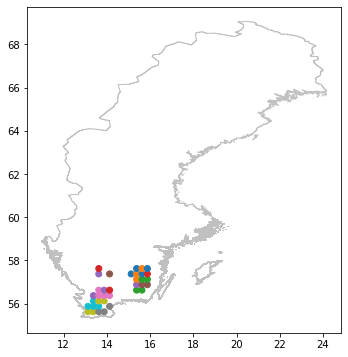

In [84]:
tc_matlab_csv = r"C:\git\soil-moisture-sweden\analysis_output\tc_analysis_20210314104637\tc_matlab_results.csv"

# print(dict_swe_gldas_points)
# with open("dict_icos.json", "r") as f:
#     dict_icos = json.load(f)

tc_matlab_df = tc_matlab2pandas(tc_matlab_csv, dict_swe_gldas_points)
# print(tc_csv)
tc_matlab_df.to_csv(r"C:\git\soil-moisture-sweden\analysis_output\tc_analysis_20210314104637\tc_matlab_pandas_results.csv", index=False)
tc_metrics_output(r"C:\git\soil-moisture-sweden\analysis_output\tc_analysis_20210314104637\tc_matlab_pandas_results.csv", tc_map_output_dir, sweden_shp)

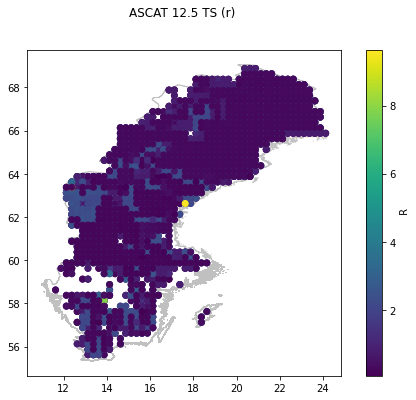

In [45]:
# tc_metrics_csv = r"../analysis_output/tc_analysis_20210314104637/tc_metrics.csv"
# tc_map_output_dir = r"../analysis_output/tc_evaluation_maps"

# tc_metrics_output(tc_metrics_csv, tc_map_output_dir, sweden_shp)